In [6]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('B://workspace/tensorflow')

import numpy as np

from torch.utils.data import DataLoader, Subset

from src.models.RDF import RDFNetwork
from src.dataset.Argo import Argo3DTemperatureDataset
from src.config.params import Areas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from src.plot.sst import _range
from src.dataset.Argo import depthMap
from src.config.constants import Alphabet

def get_lon(lon):
    lon_s = 360 + lon[0] if lon[0] < 0 else lon[0]
    lon_e = 360 + lon[1] if lon[1] < 0 else lon[1]
    
    print(lon_s, lon_e)
    
    return [lon_s, lon_e]

def get_lat(lat):
    return lat + 80

def split_dataset(area):
    dataset = Argo3DTemperatureDataset(lon=get_lon(np.array(area['lon'])), lat=get_lat(np.array(area['lat'])), depth=[0, 58])

    # 计算数据集大小和划分点
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    
    # 顺序划分数据集
    train_dataset = Subset(dataset, range(0, train_size))
    val_dataset = Subset(dataset, range(train_size, train_size + val_size))
    test_dataset = Subset(dataset, range(train_size + val_size, total_size))
    
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    return train_loader, val_loader, test_loader

def get_input(loader):
    input, output = next(iter(loader))
    input = input.reshape(-1, input.shape[-1])
    output = output.reshape(-1, output.shape[-1])
    return input, output

def train_and_evaluate(input, output, test_input, test_output, model):
    model.fit(input, output)
    score = model.score(test_input, test_output)
    score = np.around(score, 3)
    return model, score

def rmse(pred, true):
    true = true.numpy()
    rmses = []
    
    for i in range(58):
        pred_temp = pred[:, i].reshape(20, 20)
        true_temp = true[:, i].reshape(20, 20)
        mse = np.nanmean((pred_temp - true_temp) ** 2)
        rmse = np.sqrt(mse)
        rmses.append(rmse)
        
    # 计算 1000dbr 以上的 RMSE
    rmses_1000u = rmses[:45]
    # 计算 1000dbr 以下的 RMSE
    rmses_1000d = rmses[45:]
    
    return np.nanmean(rmses_1000u), np.nanmean(rmses_1000d)

def reshape(data):
    data[data > 99] = np.nan
    return data.reshape(20, 20, 58)

def profile_u(data):
    return np.transpose(data[1, :, :35], (1, 0))


def plot_sst_station(profile, ax, levels, label, lat, ylabel=True):
    
    if ylabel:
        # 将 depth 设置为 Y 轴刻度
        ax.set_yticks(np.arange(0, len(depthMap[:35]), 10))
        ax.set_yticks(np.arange(0, len(depthMap[:35]), 5), minor=True)
        # 设置对应的深度值标签
        ax.set_yticklabels(depthMap[:35][::10])
    else:
        ax.axes.yaxis.set_ticklabels([])
    
    # 设置 X 轴刻度，2004年1月到2024年3月
    ax.set_xticks(np.arange(0, 20, 4))
    # 设置小刻度
    xticks_labels = [f"{x:.0f}°N" if x >= 0 else f"{abs(x):.0f}°S" for x in _range(lat, 4)]
    ax.set_xticks(np.arange(0, 20, 1), minor=True)
    ax.set_xticklabels(xticks_labels)
    
    # 修改文本位置到左上角，使用相对坐标
    ax.text(0.02, 0.12, label, 
            fontsize=8, 
            color='orange',
            transform=ax.transAxes,  # 使用相对坐标系统
            verticalalignment='bottom'
    )

    ax.contourf(profile, levels=levels)
    ax.contour(profile, colors='black', alpha=0.5, linewidths=0.2, linestyles='--', levels=30)
    contour_lines = ax.contour(profile, colors='black', linewidths=0.5)
    
    ax.clabel(contour_lines, inline=True, colors='black', fontsize=5, fmt='%d', manual=False)
        
    ax.invert_yaxis()


In [5]:
# ---- 实验 1： 同时选取所有研究区域中的任意一个观测点，观察模型剖面预测效果  ----

list = []
modules = []
epochs = 5

for area in Areas:
    network = RDFNetwork()
    model = network.get_model()
    train_loader, val_loader, test_loader = split_dataset(area)

    input, output = get_input(train_loader)
    val_input, val_output = get_input(val_loader)
    
    for epoch in range(epochs):
        train_and_evaluate(input, output, val_input, val_output, model)
    
    modules.append(model)


200 220
220 240
70 90
320 340


200 220


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Area: a), RMSE: 0.19767030483881204, 49.99797758998429 
            origin: max = 26.207000732421875, min = 1.9947999715805054 
            predict: max = 26.20707733154297, min = 1.9962419712543487
220 240


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Area: b), RMSE: 0.17603313708532597, 0.020742458349000438 
            origin: max = 29.280500411987305, min = 2.0573999881744385 
            predict: max = 29.281386394500732, min = 2.0671689748764037
70 90


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Area: c), RMSE: 0.7311094143335849, 0.12425043589616126 
            origin: max = 29.539199829101562, min = 2.588599920272827 
            predict: max = 29.54075107574463, min = 2.6509920358657837
320 340


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Area: d), RMSE: 0.17397772189089383, 0.10092816180901588 
            origin: max = 23.41029930114746, min = 3.5006000995635986 
            predict: max = 23.397822437286376, min = 3.522441065311432


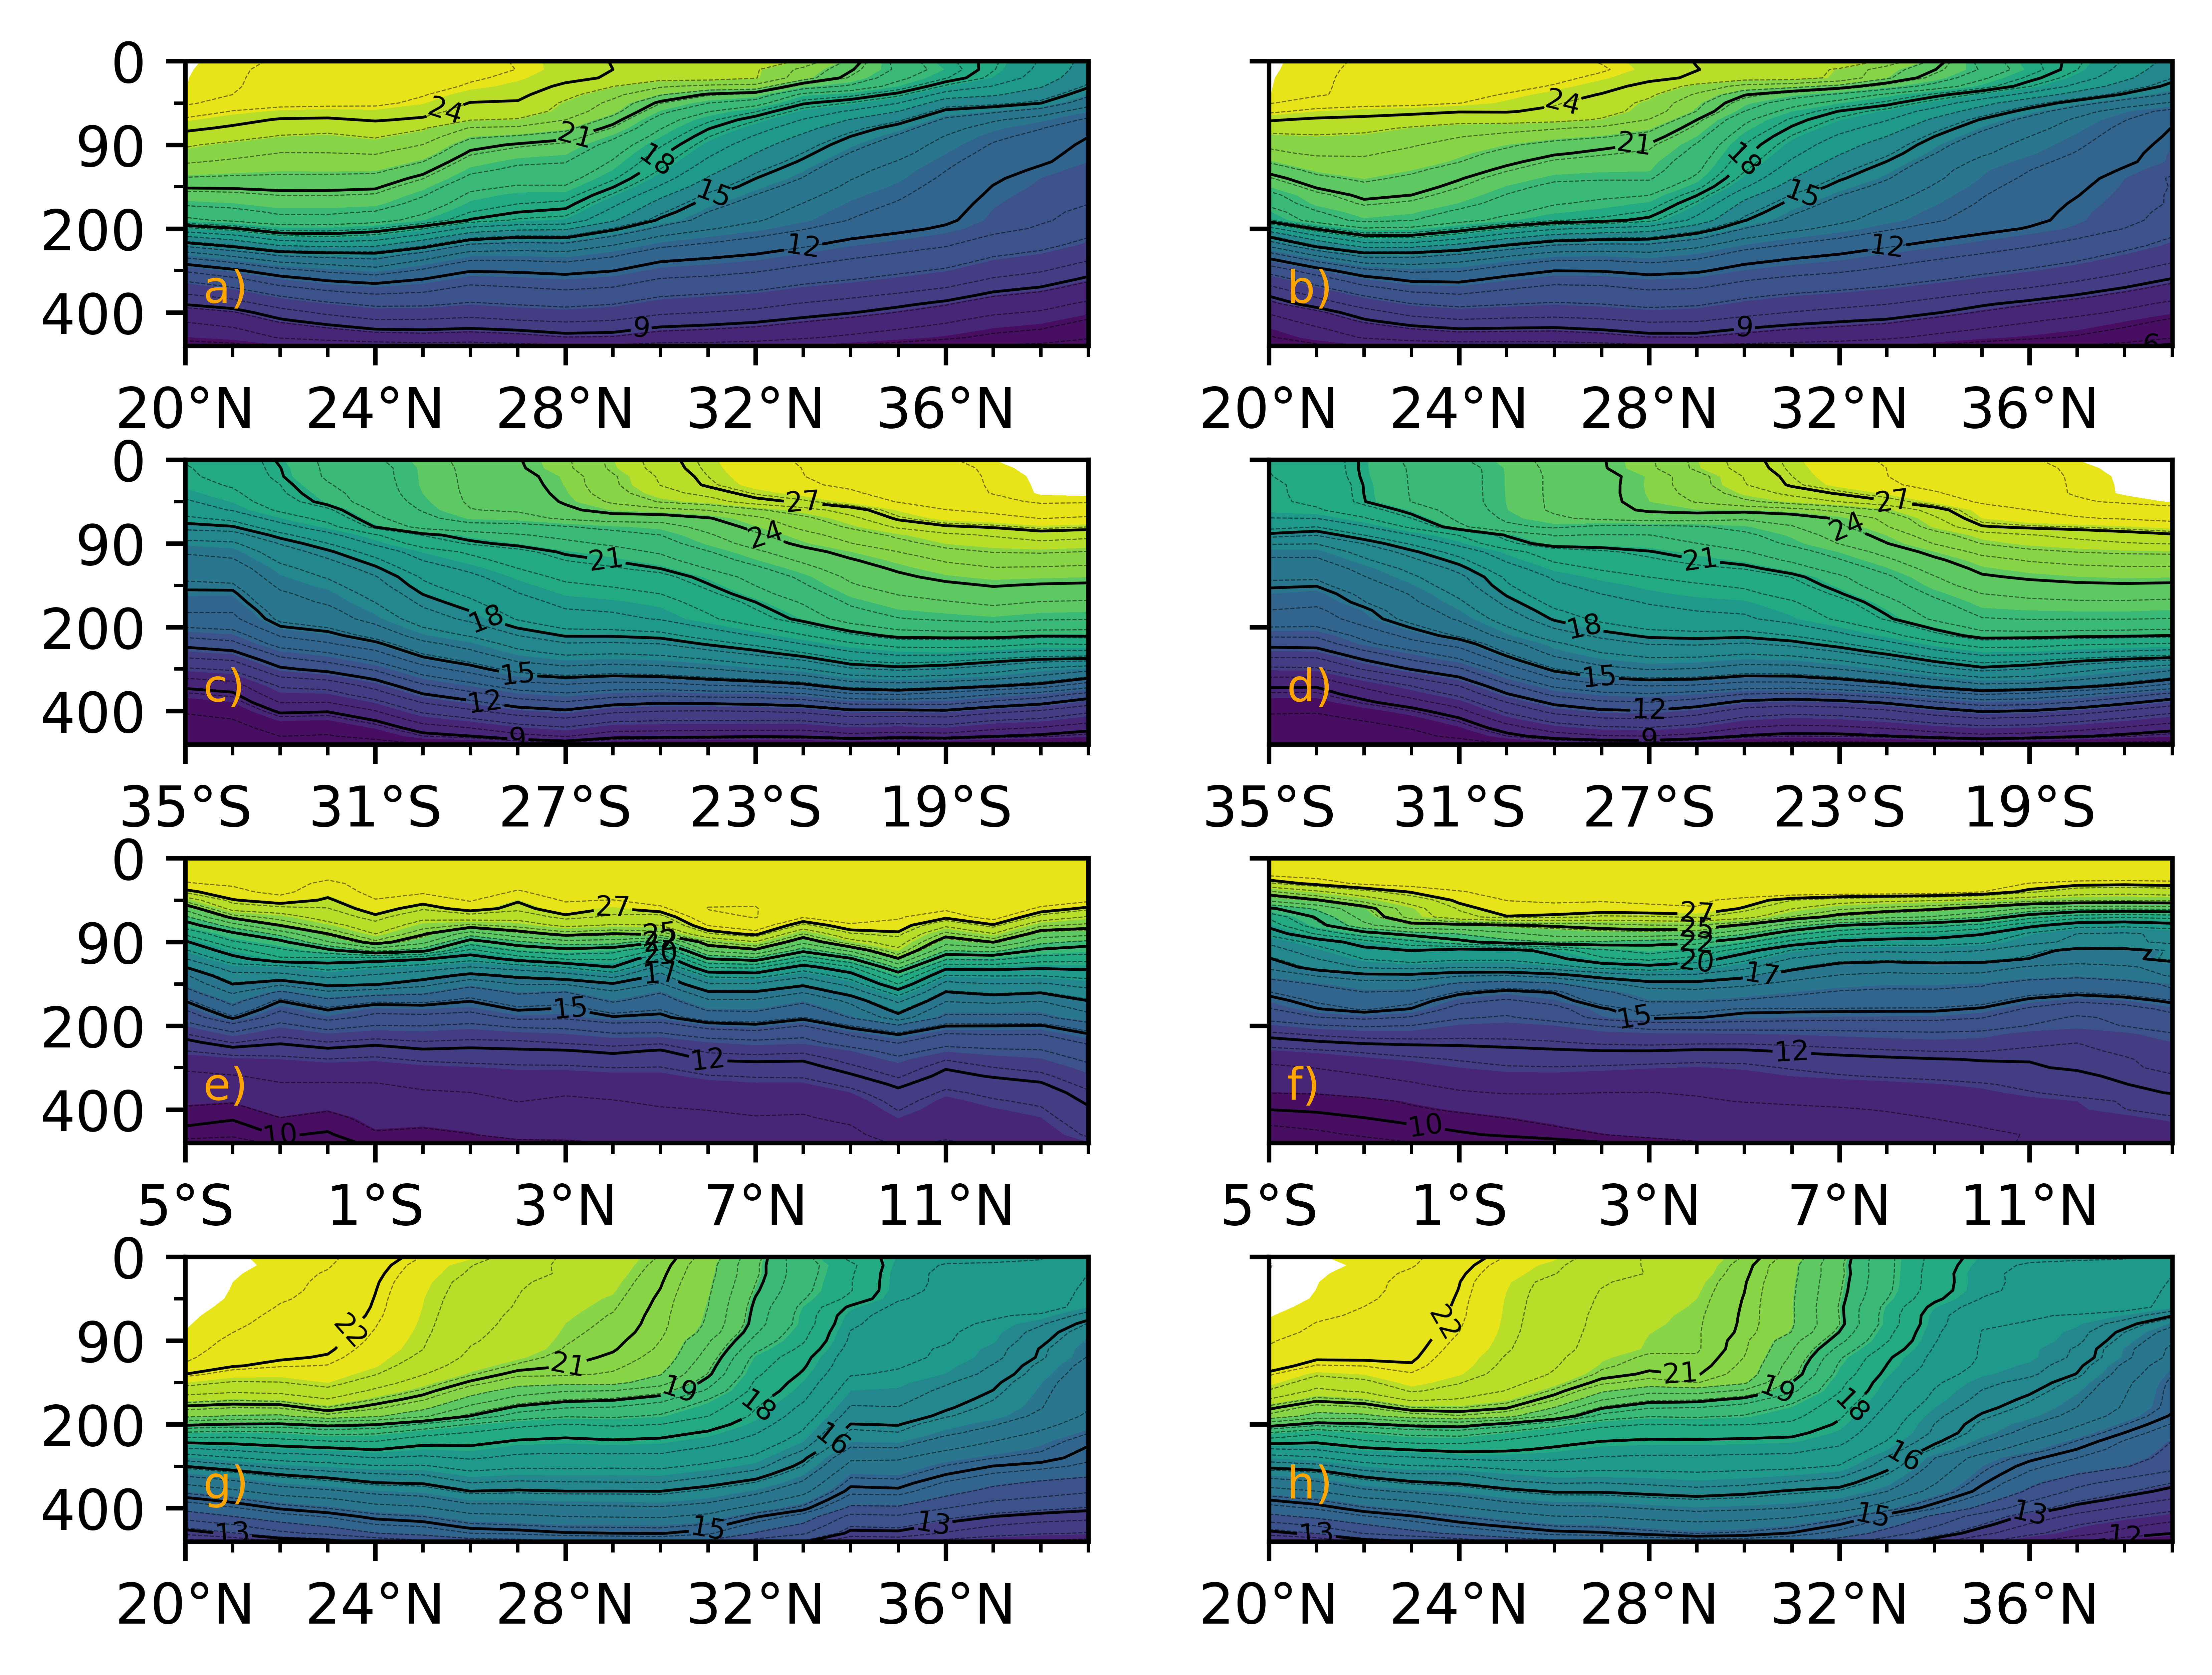

In [4]:
# 画图
from matplotlib import pyplot as plt
from src.plot.base import create_axes

axes = create_axes(4, 2)

# 调整子图间距
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for i in range(4):
    area = Areas[i]
    model = modules[i]

    train_loader, val_loader, test_loader = split_dataset(area)
    
    test_input, test_output = get_input(test_loader)
    
    result = model.predict(test_input)
    
    mse_1000u, mse_1000d = rmse(result, test_output);

    list.append([reshape(result), reshape(test_output)])
    
    print(f"Area: {area['title']}, RMSE: {mse_1000u}, {mse_1000d} \n\
            origin: max = {np.nanmax(test_output)}, min = {np.nanmin(test_output)} \n\
            predict: max = {np.nanmax(result)}, min = {np.nanmin(result)}")
    
    left_index = 2 * i
    mid_index = 2 * i + 1

    ax_l, ax_r = axes[i]

    pred, origin = list[i]
    
    pred_profile = profile_u(pred)
    origin_profile = profile_u(origin.numpy())
    
    vmin = np.around(np.min([np.nanmin(pred_profile), np.nanmin(origin_profile)]), 0)
    vmax = np.around(np.max([np.nanmax(pred_profile), np.nanmax(origin_profile)]), 0)
    
    levels = np.linspace(vmin, vmax, 15)
    
    plot_sst_station(pred_profile, ax_l, levels, f"{Alphabet[left_index]})", area['lat'])
    plot_sst_station(origin_profile, ax_r, levels, f"{Alphabet[mid_index]}) ", area['lat'], ylabel=False)
